## Satellite Data Classification
---
This notebook explores the task of satellite data classification using CNN (Convolution Nural Networks)

**SATELLITE_DATA**
- CLOUDY
- DESERT
- GREEN_AREA
- WATER

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = './datasets/satellite_data/'

In [3]:
images_dict = {
    "cloudy" : os.path.join(dataset_dir + "cloudy"),
    "desert" : os.path.join(dataset_dir + "desert"),
    "green_area" : os.path.join(dataset_dir + "green_area"),
    "water" : os.path.join(dataset_dir + "water")
}

labels_dict = {
    "cloudy" : 0,
    "desert" : 1,
    "green_area" : 2,
    "water" : 3
}

In [4]:
total_images = 0
for category, path in images_dict.items():
    file_list = os.listdir(path)
    num_images = len(file_list)
    print(f"{category}: {num_images} images")
    total_images += num_images

print(f"Total number of images: {total_images}")

cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images
Total number of images: 5631


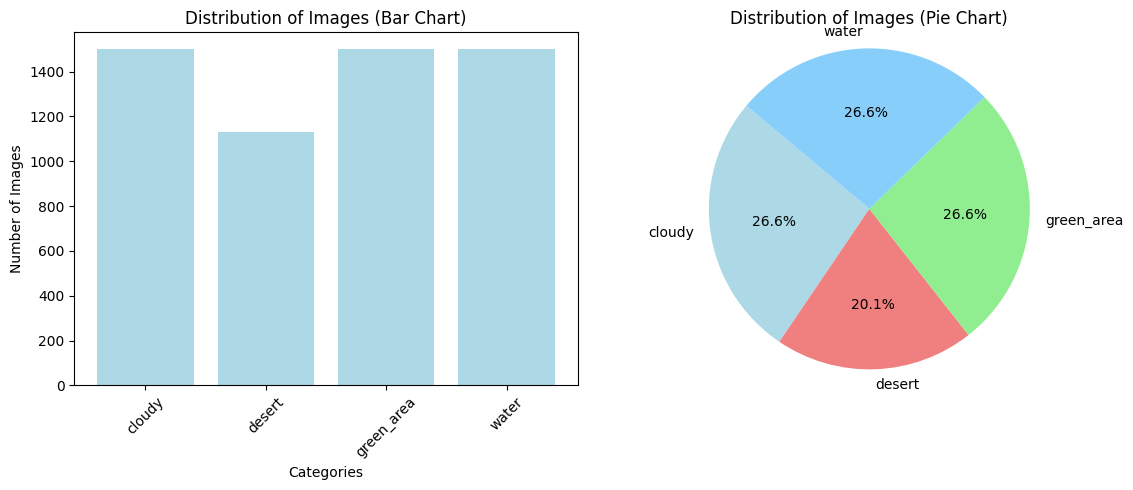

In [5]:
categories = list(images_dict.keys())
num_images = [len(os.listdir(images_dict[cat])) for cat in categories]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(categories, num_images, color='lightblue')
ax1.set_xlabel('Categories')
ax1.set_ylabel('Number of Images')
ax1.set_title('Distribution of Images (Bar Chart)')
ax1.tick_params(axis='x', rotation=45)

ax2.pie(num_images, labels=categories, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightcoral', 'lightgreen', 'lightskyblue'])
ax2.set_title('Distribution of Images (Pie Chart)')
ax2.axis('equal')

plt.tight_layout()
plt.show()

In [6]:
def display_samples(images_dict, labels_dict, rows=5, cols=4):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    for i, (category, path) in enumerate(images_dict.items()):
        image_files = os.listdir(path)[:5]
        for j, image_file in enumerate(image_files):
            img_path = os.path.join(path, image_file)
            img = Image.open(img_path)
            axes[j, i].imshow(img)
            axes[j, i].set_title(f"{category}\n{img.size}")
            axes[j, i].axis('off')
    plt.tight_layout()
    plt.show()


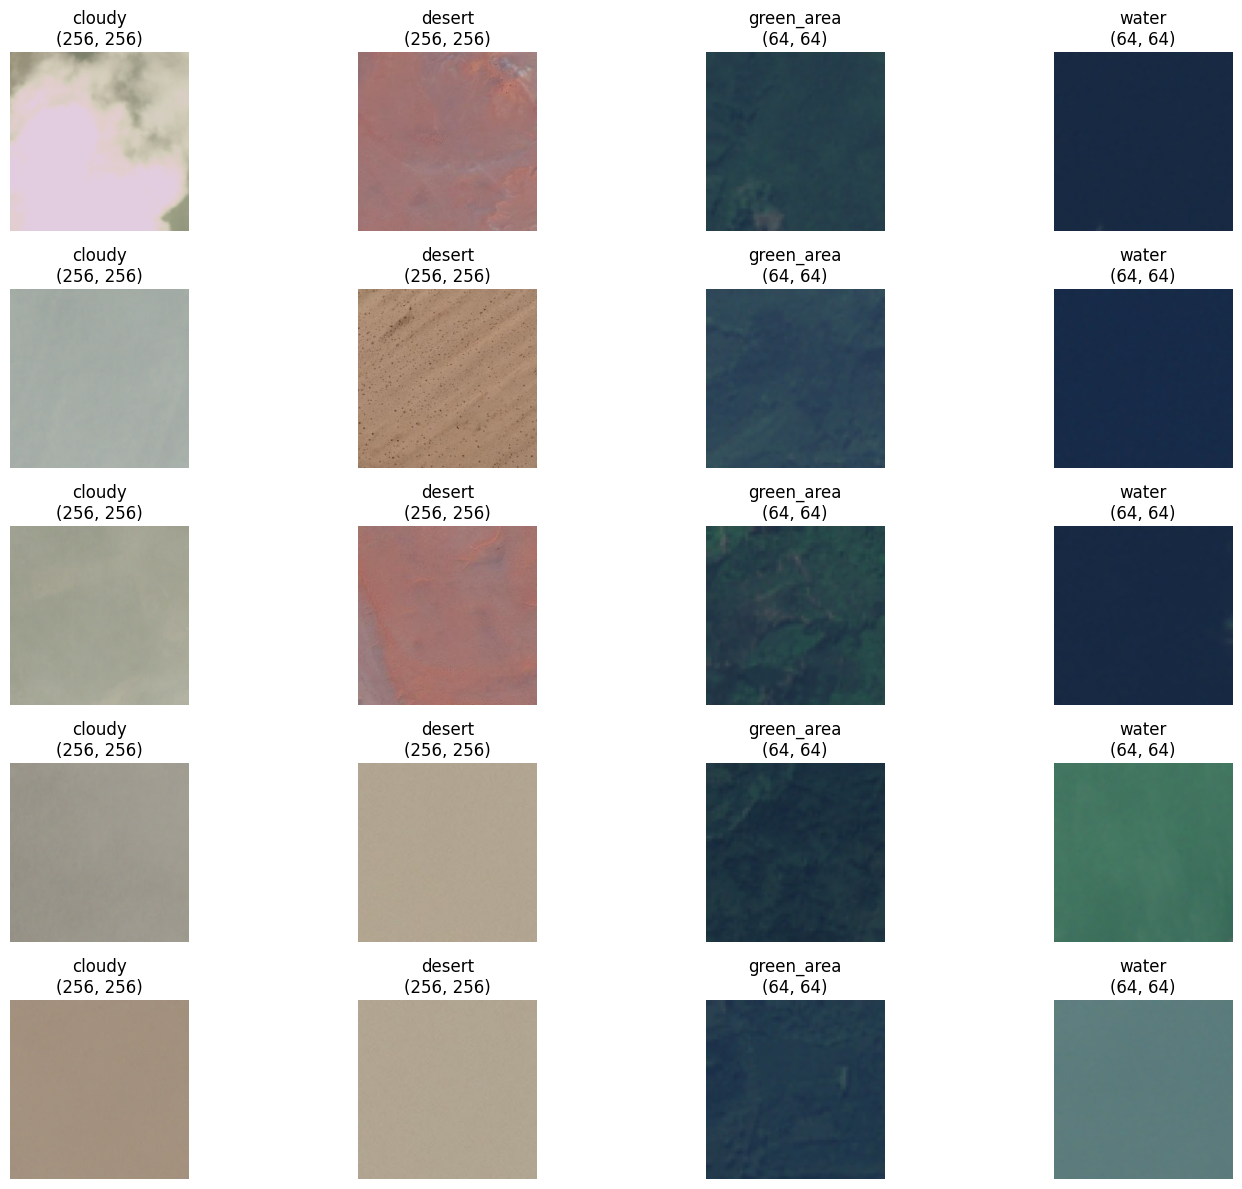

In [7]:
display_samples(images_dict, labels_dict)

In [8]:
height = 64
width = 64
batch_size = 128
dropout = 0.2
nc = len(labels_dict)

In [9]:
X, y = [], []

for name, dir in images_dict.items():
    print(dir)
    paths = os.listdir(dir)
    for path in paths:
        img = cv2.imread(os.path.join(dir,path))
        resized = cv2.resize(img,(height,width))
        X.append(resized)
        y.append(labels_dict[name])

./datasets/satellite_data/cloudy
./datasets/satellite_data/desert
./datasets/satellite_data/green_area
./datasets/satellite_data/water


In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [13]:
model = Sequential([
    layers.Input(shape=(height, width, 3)),
    layers.Rescaling(1./255),
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(dropout),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(nc)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

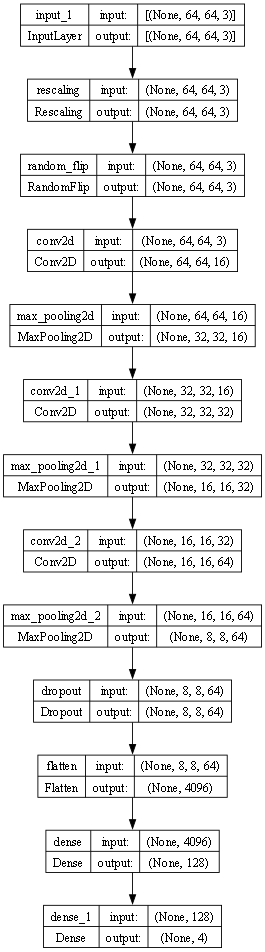

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [16]:
epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/20
29/29 [==============================] - 8s 219ms/step - loss: 0.7625 - accuracy: 0.5938 - val_loss: 0.4739 - val_accuracy: 0.7519
Epoch 2/20
29/29 [==============================] - 6s 215ms/step - loss: 0.4866 - accuracy: 0.7212 - val_loss: 0.4444 - val_accuracy: 0.8049
Epoch 3/20
29/29 [==============================] - 6s 200ms/step - loss: 0.4209 - accuracy: 0.8314 - val_loss: 0.3443 - val_accuracy: 0.8636
Epoch 4/20
29/29 [==============================] - 6s 199ms/step - loss: 0.3448 - accuracy: 0.8598 - val_loss: 0.3205 - val_accuracy: 0.8788
Epoch 5/20
29/29 [==============================] - 6s 197ms/step - loss: 0.3212 - accuracy: 0.8709 - val_loss: 0.2860 - val_accuracy: 0.8807
Epoch 6/20
29/29 [==============================] - 6s 211ms/step - loss: 0.3074 - accuracy: 0.8725 - val_loss: 0.2731 - val_accuracy: 0.8996
Epoch 7/20
29/29 [==============================] - 6s 206ms/step - loss: 0.2783 - accuracy: 0.8907 - val_loss: 0.2457 - val_accuracy: 0.8996
Epoch 

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                   

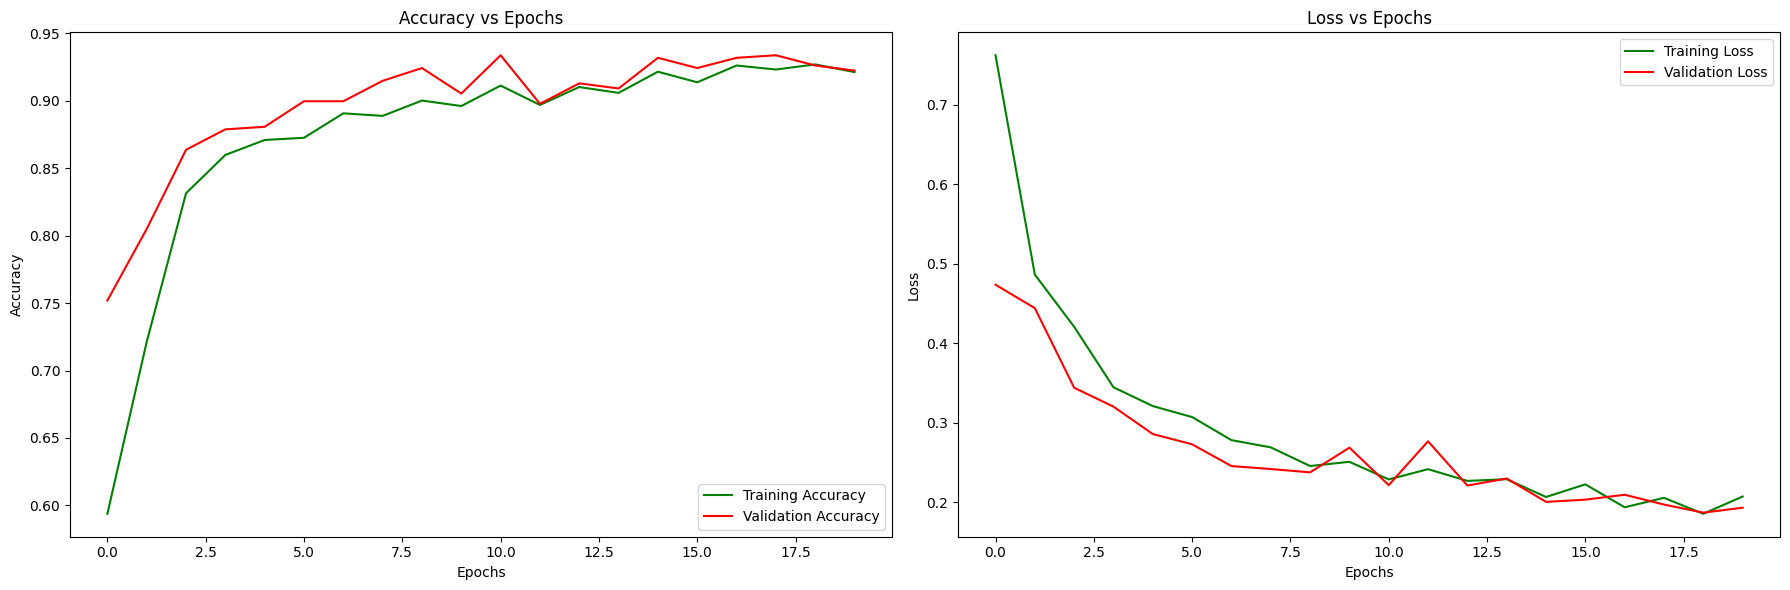

In [18]:
epochs_range = range(epochs)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(epochs_range, accuracy, label='Training Accuracy', color='green')
ax1.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red')
ax1.set_title('Accuracy vs Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(loc='lower right')

ax2.plot(epochs_range, loss, label='Training Loss', color='green')
ax2.plot(epochs_range, val_loss, label='Validation Loss', color='red')
ax2.set_title('Loss vs Epochs')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
model.evaluate(X_test,y_test)

44/44 [==============================] - 1s 20ms/step - loss: 0.1888 - accuracy: 0.9290


[0.18879686295986176, 0.9289772510528564]

In [20]:
y_pred = model.predict(X_test)

y_actual_pred = [np.argmax(i) for i in y_pred]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_actual_pred)
cm

44/44 [==============================] - 1s 17ms/step


<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[394,  11,   2,   2],
       [ 10, 278,   0,   0],
       [  0,   0, 302,  59],
       [  1,   0,  15, 334]])>

Text(58.222222222222214, 0.5, 'Truth')

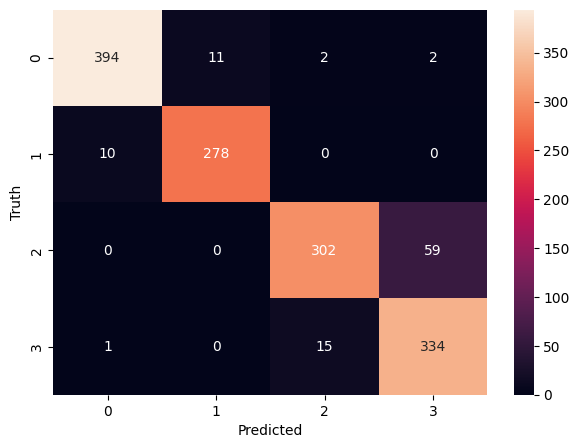

In [21]:
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

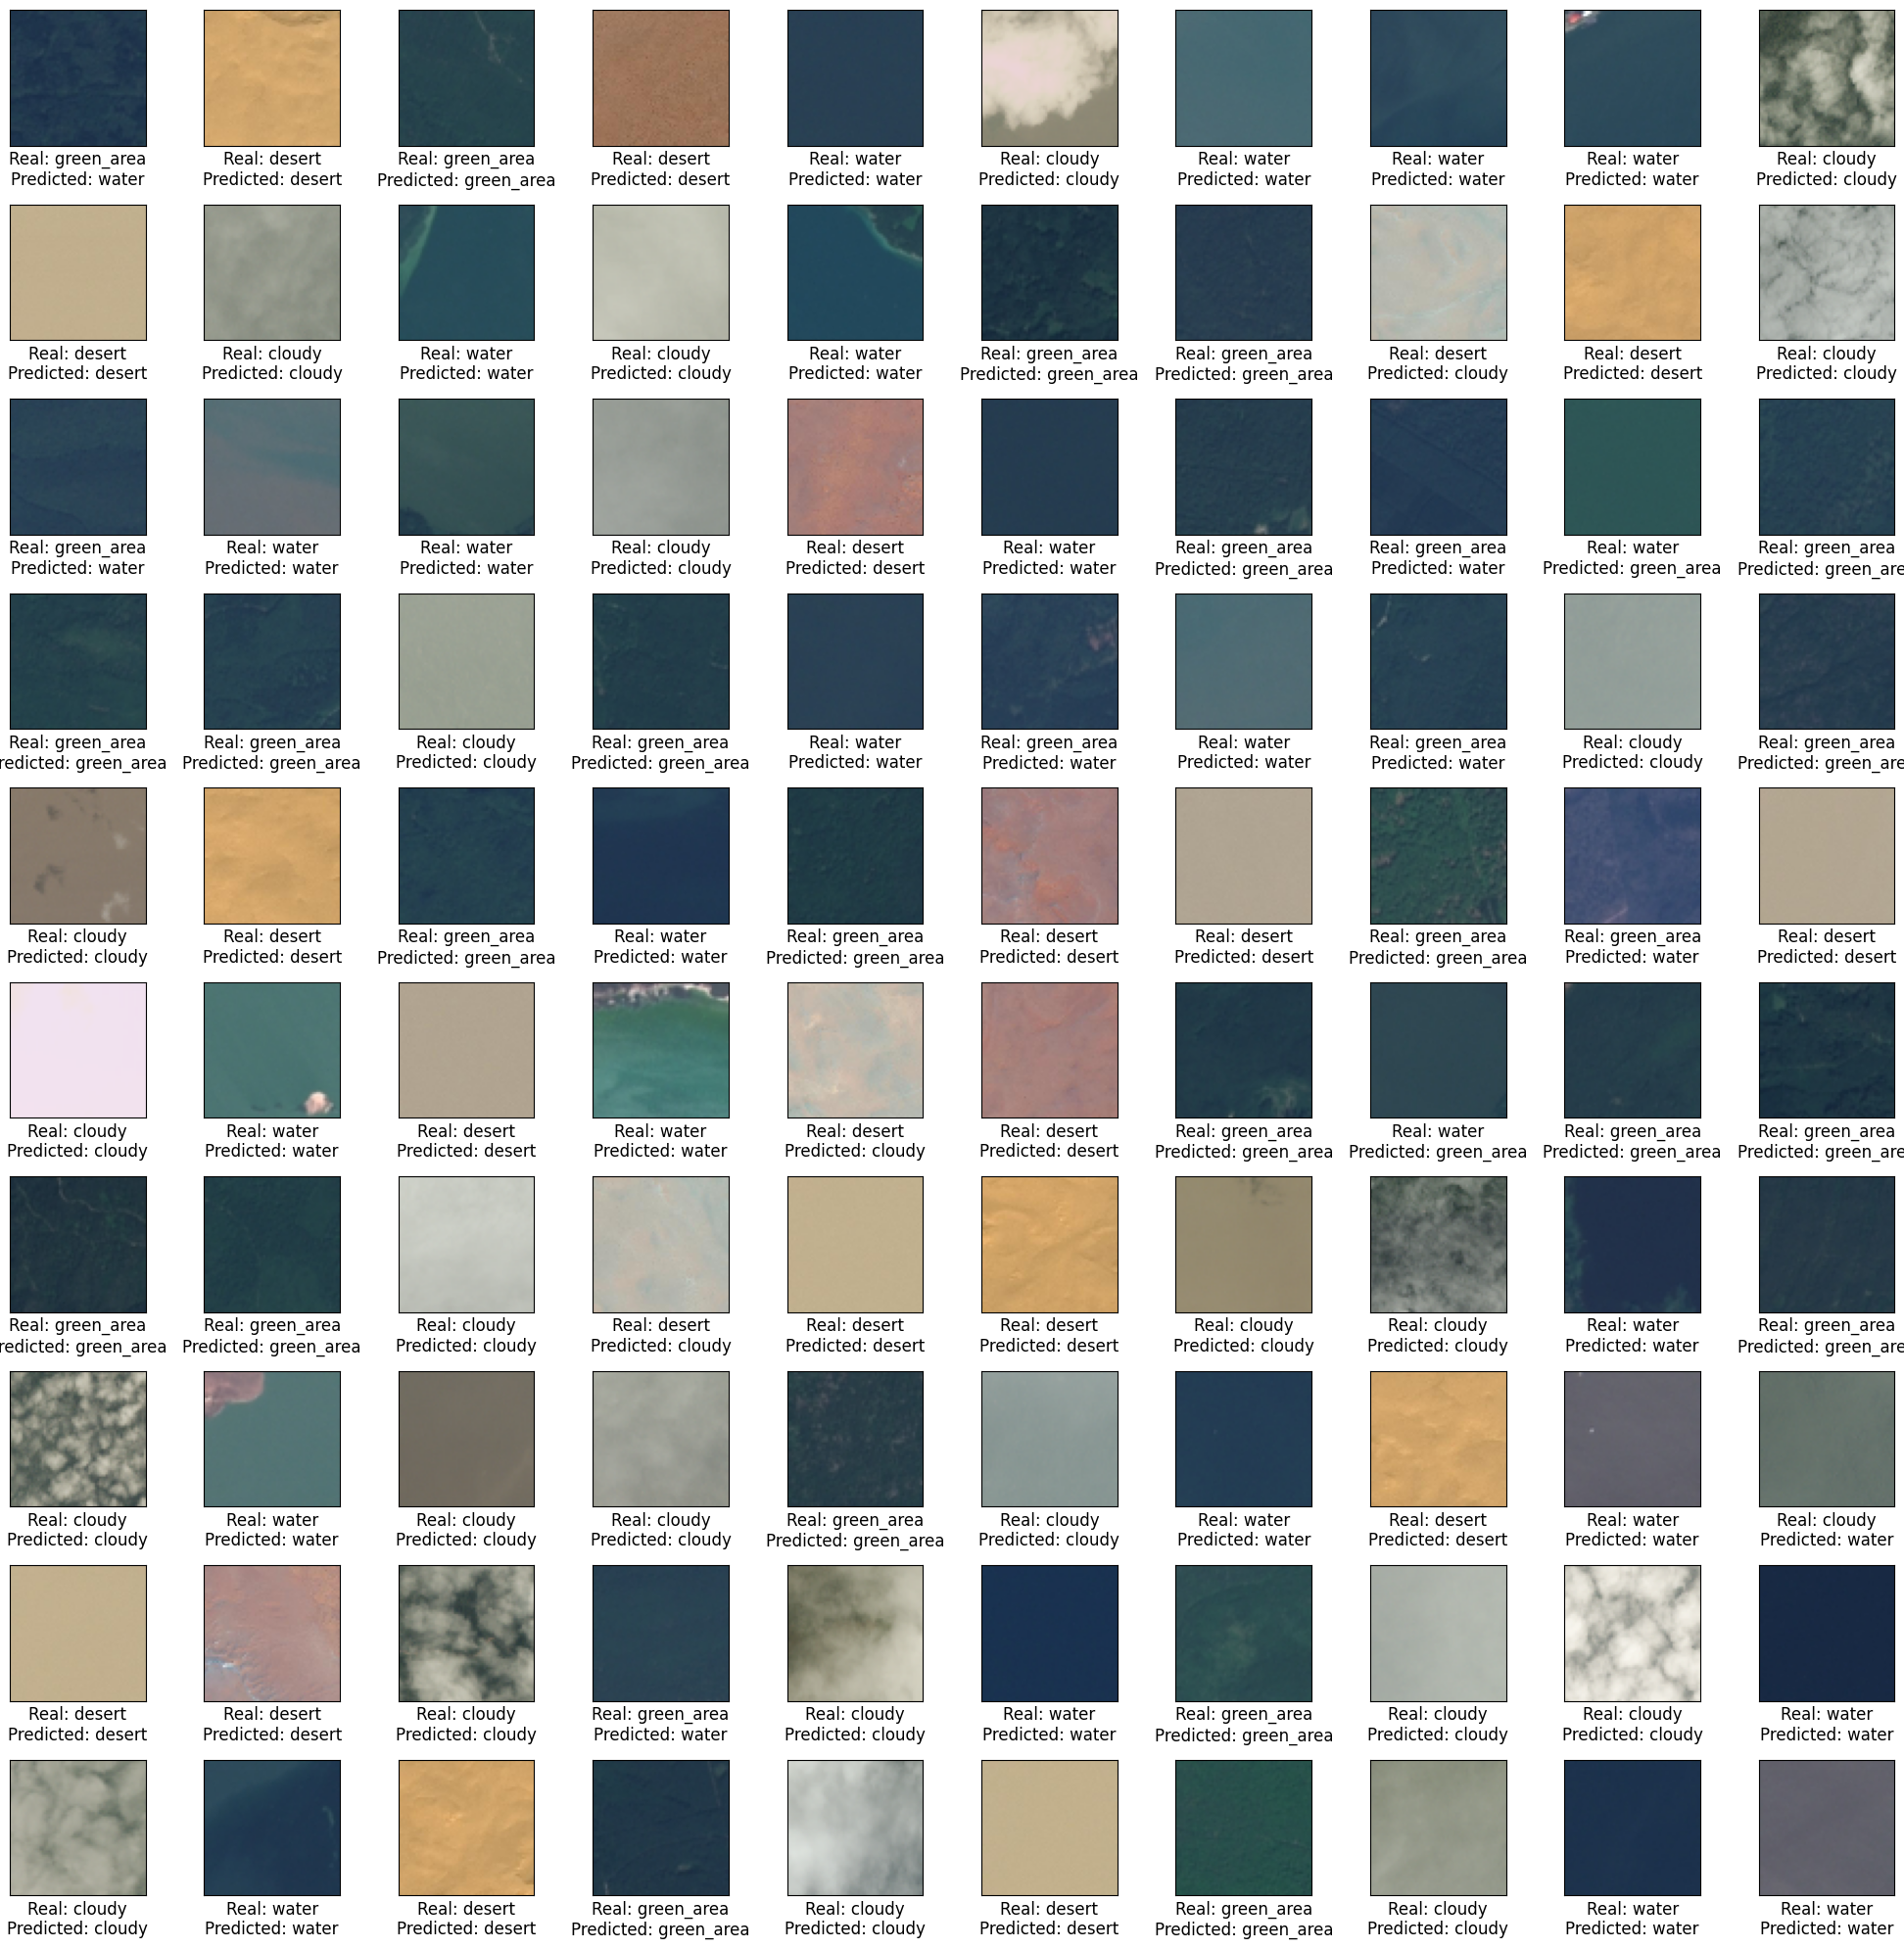

In [23]:
classes = ["cloudy", "desert", "green_area", "water"]
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    row = i // 10
    col = i % 10
    img = X_test[i]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[row, col].imshow(img_rgb)
    ax[row, col].set_xlabel(f'Real: {classes[y_test[i]]}\nPredicted: {classes[y_actual_pred[i]]}', fontsize=12)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    ax[row, col].set_aspect('equal')

for i in range(100, 100):
    row = i // 10
    col = i % 10
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()